In [2]:
# import dependencies
import os
from datetime import datetime
from typing import List

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


In [3]:
START = datetime(2016, 1, 1)
END = datetime(2021, 2, 16)
BUCKET = 1  # day

# COLUMNS = ["VOLUME_fut", "VOLUME_etf", "VOLUME_opt"] # change
# TARGET = "VOLUME_fut_target" # change

In [4]:
# Load data
global_markets_volumes_path = "data/VOLUMES.csv"
vix_path = "data/VIX.csv"
sp500_path = "data/SP500.csv"
gold_path= "data/GOLD.csv"
euro_usd_path = "data/EURUSD.csv"
bonds_path = "data/10YBONDYIELDS.csv"

In [5]:
def load_data(path: str, target:str) -> pd.DataFrame:
    assert target in ["gm", "vix", "sp500", "gold", "eurusd", "bonds"], f"Invaid target: {target}"

    root = os.path.dirname(os.getcwd())
    df = pd.read_csv(f"{root}/{path}")

    # rename columns to lower case
    df.columns = map(str.lower, df.columns)
    if target == "gm":
        index = "business date"
    else:
        index = "date"
    new_columns = ["date"] + [column + f"_{target}" for column in df.columns if column != index]
    # Add _target to columns except Date
    df.rename(columns=dict(zip(df.columns, new_columns)),inplace=True)
    # Remove space from columns
    df.columns = df.columns.str.replace(" ", "_")
    return df.set_index("date")

def join_dfs(df_list: List) -> pd.DataFrame:
    pdf = df_list[0]
    for df in df_list[1:]:
        pdf = pdf.join(df, how="left")
    assert len(pdf) == len(df_list[0])
    return pdf

In [6]:
gm_volumes = load_data(global_markets_volumes_path, "gm")
vix = load_data(vix_path, "vix")
sp500 = load_data(sp500_path, "sp500")
gold = load_data(gold_path, "gold")
euro_usd = load_data(euro_usd_path, "eurusd")
bonds = load_data(bonds_path, "bonds")

In [7]:
len(gm_volumes)

1328

In [8]:
all_dfs = [gm_volumes, vix, sp500, gold, euro_usd, bonds]
all_data = join_dfs(all_dfs)
all_data

,volume_gm,vix_close_vix,adj_close_sp500,volume_sp500,adj_close_gold,volume_gold,usd_eurusd,adj_close_bonds,volume_bonds
date,,,,,,,,,
1/4/2016,1364.873049,20.70,2012.660034,4.304880e+09,1075.099976,143.0,1.0898,2.245,0.0
1/5/2016,4826.624586,19.34,2016.709961,3.706620e+09,1078.400024,82.0,1.0746,2.248,0.0
1/6/2016,1751.952884,20.59,1990.260010,4.336660e+09,1091.900024,52.0,1.0742,2.177,0.0
1/7/2016,5842.829025,24.99,1943.089966,5.076590e+09,1107.699951,122.0,1.0868,2.153,0.0
1/8/2016,1592.794266,27.01,1922.030029,4.664940e+09,1097.800049,98.0,1.0861,2.130,0.0
...,...,...,...,...,...,...,...,...,...
2/10/2021,3190.066116,21.99,3909.879883,4.815380e+09,1840.599976,543.0,1.2127,1.133,0.0
2/11/2021,2427.720356,21.25,3916.379883,4.570080e+09,1824.900024,602.0,1.2147,1.158,0.0
2/12/2021,3232.310708,19.97,3934.830078,4.119260e+09,1821.599976,259.0,1.2108,1.200,0.0


<Axes: xlabel='date'>

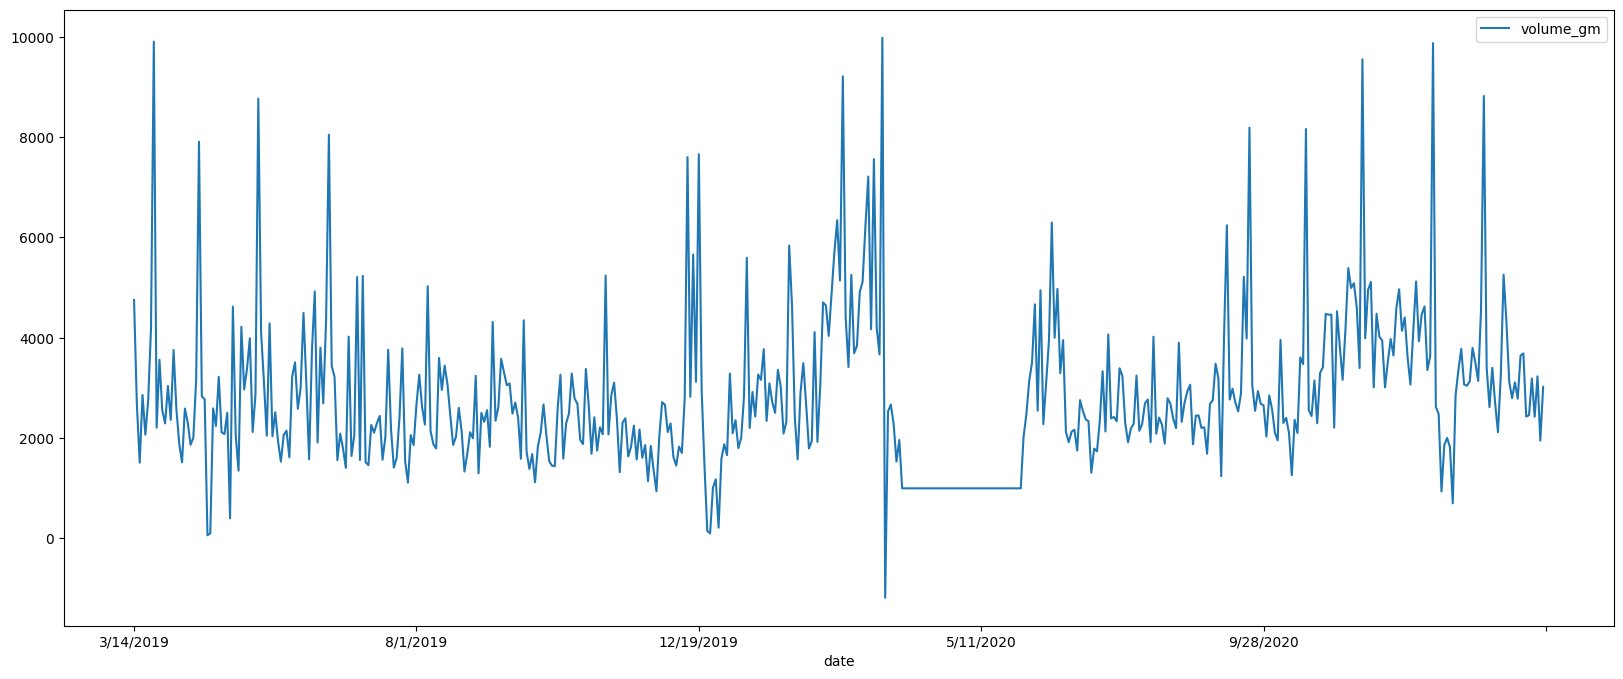

In [27]:
# No trend
# Yes seasonality around 30 days
all_data.iloc[-500:].plot(y='volume_gm', figsize=[20, 8])

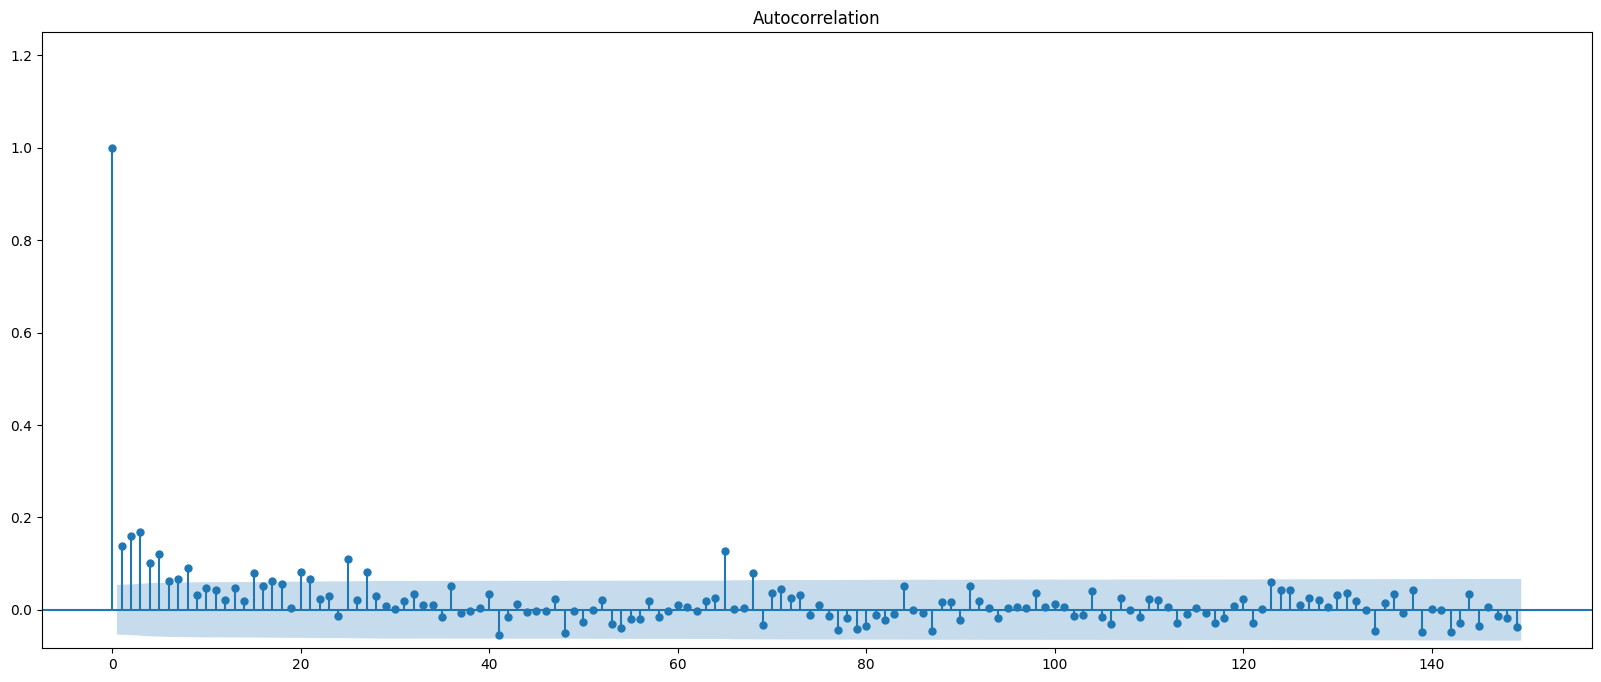

In [25]:
fig, ax = plt.subplots(figsize=(20, 8))
plt_pacf = plot_acf(all_data['volume_gm'], 
                    ax = ax, 
                    lags = np.arange(150), 
                    auto_ylims = True)

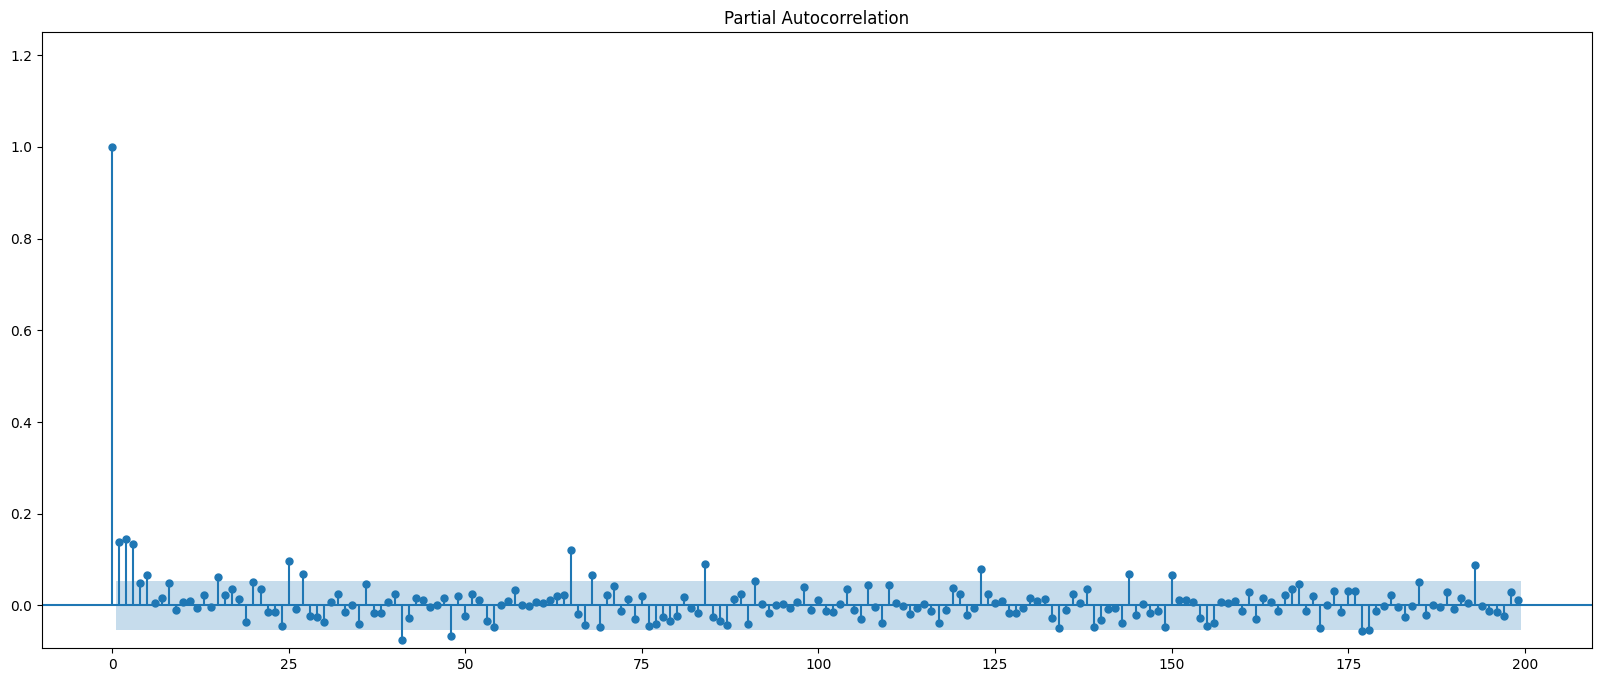

In [26]:
fig, ax = plt.subplots(figsize=(20, 8))
plt_pacf = plot_pacf(all_data['volume_gm'], 
                     ax = ax, 
                     lags = np.arange(200), 
                     auto_ylims = True, 
                     method='ywm')